# Production d'une étude de marché

## 0. Paramétrage de l'environnement de travail

In [1]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.mlab as mlab
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as st
import statsmodels.api as sm

from scipy.stats import ks_2samp
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import decomposition, preprocessing
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist

In [2]:
sns.set_context('talk')
sns.set_palette('Set1')

In [3]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                      plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
            plt.plot(np.cos(an), np.sin(an))
            plt.axis('equal')

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(10,10))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [4]:
vegetaux = pd.read_csv('C:/Users/cecil/OneDrive/Documents/Formation - Data Analyst/Projets/P5_guillot_cecile/vegetaux_2017.csv')
animaux = pd.read_csv('C:/Users/cecil/OneDrive/Documents/Formation - Data Analyst/Projets/P5_guillot_cecile/animaux_2017.csv')
population = pd.read_csv('C:/Users/cecil/OneDrive/Documents/Formation - Data Analyst/Projets/P5_guillot_cecile/population_2017.csv')

## 1. Création du DataFrame et des variables nécessaires à l'étude

Les données utilisées ici sont issues du site de la FAO (http://www.fao.org/faostat/fr/#data). On a découpé nos données en trois fichiers csv contenant les informations sur les bilans alimentaires animaux et végétaux de 2017 et les informations sur la population de chaque pays en 2017. Le choix s'est porté sur l'année 2017 car il s'agit de l'année où l'on dispose de toutes les données nécessaires les plus récentes. Concernant la sélection des pays, pour éviter la présence d'un doublon, la Chine n'a pas été sélectionné en tant qu'agrégat. En revanche, les données de la Chine sont présentes à travers une division en quatre : la Chine continentale, Macao, Taïwan et Hong Kong.

### 1.1. Nettoyage des fichiers

Avant de débuter toute analyse, on va nettoyer nos différents fichiers. On commence d'abord par rechercher les valeurs manquantes.

In [5]:
print('Détails des valeurs manquantes pour la population:\n' + str(population.isna().sum()) + '\n')
print('Détails des valeurs manquantes pour le bilan alimentaire des produits animaux:\n' + str(animaux.isna().sum()) + '\n' )
print('Détails des valeurs manquantes pour le bilan alimentaire des produits végétaux:\n' + str(vegetaux.isna().sum()) + '\n' )

Détails des valeurs manquantes pour la population:
Code Domaine              0
Domaine                   0
Code zone                 0
Zone                      0
Code Élément              0
Élément                   0
Code Produit              0
Produit                   0
Code année                0
Année                     0
Unité                     0
Valeur                    0
Symbole                   0
Description du Symbole    0
dtype: int64

Détails des valeurs manquantes pour le bilan alimentaire des produits animaux:
Code Domaine              0
Domaine                   0
Code zone                 0
Zone                      0
Code Élément              0
Élément                   0
Code Produit              0
Produit                   0
Code année                0
Année                     0
Unité                     0
Valeur                    0
Symbole                   0
Description du Symbole    0
dtype: int64

Détails des valeurs manquantes pour le bilan alimentaire d

Aucune valeur manquante ne se trouve dans nos données. On regarde ensuite s'il existe des valeurs dupliquées.

In [6]:
print('Valeurs dupliquées pour la population : ' + str(population.duplicated().sum()))
print('Valeurs dupliquées pour le bilan alimentaire des produits animaux : ' + str(animaux.duplicated().sum()))
print('Valeurs dupliquées pour le bilan alimentaire des produits végétaux : ' + str(vegetaux.duplicated().sum()))

Valeurs dupliquées pour la population : 0
Valeurs dupliquées pour le bilan alimentaire des produits animaux : 0
Valeurs dupliquées pour le bilan alimentaire des produits végétaux : 0


Aucune valeur dupliquée ne se trouve dans nos données. On peut donc créer les quatre variables nécessaires à la base de notre étude de marché. 

### 1.2. Création des différentes variables nécessaires à l'étude de marché

Pour notre étude de marché, nous allons créer quatre variables pour chaque pays de notre échantillon : une variable reflétant la différence de population entre l'année courante et l'année antérieure (ici 2017 et 2016) exprimée en pourcentage, la proportion de protéines animales sur la proportion de protéines totales disponibles, la disponibilité alimentaire totale exprimée en calories par habitant et la disponibilité alimentaire totale exprimée en protéines par habitant. Ces variables vont être créer à partir des données extraites du site de la FAO.

#### 1.2.1. Création de la variable : *croissance de la population*

La variable **croissance de la population** (nommée *croissance_pop*) représente la différence de population entre l'année 2017 et l'année 2016 et est exprimée en pourcentage.

In [7]:
population = population[['Code zone', 'Zone', 'Année', 'Valeur']]
population = population.loc[(population['Année'] == 2016) | (population['Année'] == 2017)]
population['croissance_pop'] = round(population.groupby('Zone')['Valeur'].pct_change()*100,2)
population = population.dropna()
population = population.rename(columns={"Valeur" : "nb_habitants"})
population.head()

,Code zone,Zone,Année,nb_habitants,croissance_pop
3,2,Afghanistan,2017,36296.11,2.58
7,202,Afrique du Sud,2017,57009.76,1.43
11,3,Albanie,2017,2884.17,-0.08
15,4,Algérie,2017,41389.19,2.07
19,79,Allemagne,2017,82658.41,0.57


Pour chaque pays, on obtient la différence entre le nombre d'habitants de l'année 2017 et 2016 sous la forme d'un pourcentage. Un pourcentage positif montre une augmentation de la population et un pourcentage négatif indique une diminution de la population. 

#### 1.2.2. Construction du DataFrame des bilans alimentaires

Avant d'ajouter les trois variables nécessaires à notre analyse, on va créer un DataFrame contenant les bilans alimentaires des produits d'origine animale et végétale.

In [8]:
animaux['origine'] = 'animale'
vegetaux['origine'] = 'vegetale'
bilan_alim = animaux.append(vegetaux)
del animaux
del vegetaux
bilan_alim = bilan_alim[['Code zone', 'Zone', 'Code Produit', 'Produit', 'Élément', 'Année', 'Valeur', 'origine']]
bilan_alim = pd.pivot_table(bilan_alim, index=['Code zone', 'Zone', 'Code Produit', 'Produit', 'Année', 'origine'], columns= 'Élément', values='Valeur', aggfunc=np.sum).reset_index()
bilan_alim = bilan_alim.rename(columns = {'Disponibilité intérieure' : 'dispo_int', 
                                          'Disponibilité alimentaire (Kcal/personne/jour)' : 'dispo_kcal_p_j',
                                          'Disponibilité alimentaire en quantité (kg/personne/an)' : 'dispo_kg_p',
                                          'Disponibilité de matière grasse en quantité (g/personne/jour)' : 'dispo_mat_g_p_j',
                                          'Disponibilité de protéines en quantité (g/personne/jour)' : 'dispo_prot_g_p_j'})
bilan_alim.head()

Élément,Code zone,Zone,Code Produit,Produit,Année,origine,dispo_kcal_p_j,dispo_kg_p,dispo_mat_g_p_j,dispo_prot_g_p_j,dispo_int
0,1,Arménie,2511,Blé et produits,2017,vegetale,1053.0,132.49,3.97,31.35,558.0
1,1,Arménie,2513,Orge et produits,2017,vegetale,4.0,0.54,0.02,0.15,114.0
2,1,Arménie,2514,Maïs et produits,2017,vegetale,68.0,7.48,0.60,2.64,58.0
3,1,Arménie,2515,Seigle et produits,2017,vegetale,1.0,0.14,0.01,0.03,1.0
4,1,Arménie,2516,Avoine,2017,vegetale,7.0,0.65,0.12,0.26,7.0


#### 1.2.3. Création de la variable : *Proportion de protéines animales par rapport aux protéines totales*

Une fois le DataFrame des bilans alimentaires construits, on peut créer les trois variables nécessaires à notre étude de marché. 

In [9]:
bilan_alim = pd.pivot_table(bilan_alim, index=['Code zone', 'Zone'], columns='origine', values=['dispo_prot_g_p_j', 'dispo_kcal_p_j'], aggfunc=np.sum).reset_index(level=[0])
columns = bilan_alim.columns
new_index = pd.Index([e[0] + e[1] for e in columns.tolist()])
bilan_alim.columns = new_index
bilan_alim = bilan_alim.rename(columns={'dispo_kcal_p_janimale' : 'dispo_kcal_p_j_anim',
                                        'dispo_kcal_p_jvegetale' : 'dispo_kcal_p_j_veg',
                                        'dispo_prot_g_p_janimale' : 'dispo_prot_p_j_anim',
                                        'dispo_prot_g_p_jvegetale' : 'dispo_prot_p_j_veg'})

bilan_alim['prot_anim_prot_tot'] = round((bilan_alim['dispo_prot_p_j_anim']/(bilan_alim['dispo_prot_p_j_anim'] + bilan_alim['dispo_prot_p_j_veg']))*100, 2)
bilan_alim.head()

,Code zone,dispo_kcal_p_j_anim,dispo_kcal_p_j_veg,dispo_prot_p_j_anim,dispo_prot_p_j_veg,prot_anim_prot_tot
Zone,,,,,,
Arménie,1,789.0,2283.0,44.56,52.77,45.78
Afghanistan,2,190.0,1807.0,10.56,43.53,19.52
Albanie,3,1094.0,2306.0,66.32,53.18,55.50
Algérie,4,402.0,2943.0,25.70,67.15,27.68
Angola,7,210.0,2056.0,16.47,37.62,30.45


Ici, la proportion de protéines animales sur le total de protéines totales a été multiplié par 100 pour obtenir le pourcentage de protéines animales disponibles par rapport à la disponibilité de protéines totale pour chaque pays. 

In [10]:
# On ajoute les informations du tableau contenant la population pour obtenir un unique DataFrame
df = pd.merge(bilan_alim, population, on=['Zone', 'Code zone'])

In [11]:
# On supprime les dataframes population et bilan_alim pour éviter d'avoir des doublons
del bilan_alim
del population

#### 1.2.4. Création de la variable : *Disponibilité alimentaire en protéines par habitant*

On calcule la disponibilité alimentaire en terme de g de protéines par habitant. Cette disponibilité alimentaire en g de protéines ne prend pas en compte la différence entre les protéines d'origine animale et végétale.

In [12]:
df['dispo_prot_hab'] = (df['dispo_prot_p_j_anim'] + df['dispo_prot_p_j_veg']) * 365

#### 1.2.5. Création de la variable : *Disponibilité alimentaire en calories par habitant*

On calcule enfin la disponibilité alimentaire en calories par habitant pour chaque pays. Là aussi ce calcul ne prend pas en compte la différence entre les calories d'origine animale et végétale. Les chiffres obtenus seront plus élevés que pour les protéines ; ce qui est normale car on estime qu'un 1g de protéine vaut 4 kcal.

In [13]:
df['dispo_kcal_hab'] = (df['dispo_kcal_p_j_anim'] + df['dispo_kcal_p_j_veg']) * 365

### 1.3. Sélection des variables pour le reste de l'étude

Pour plus de lisibilité, on renomme la colonne 'Zone' en 'pays'. On ne sélectionne ensuite que les colonnes qui contiennent les informations les plus utiles pour le reste de notre étude de marché.

In [14]:
df = df.rename(columns={"Zone" : 'pays'})
df = df.drop(columns = {'Code zone', 'Année', 'nb_habitants', 'dispo_kcal_p_j_anim', 'dispo_kcal_p_j_veg', 'dispo_prot_p_j_anim', 'dispo_prot_p_j_veg'})
df.head()

,pays,prot_anim_prot_tot,croissance_pop,dispo_prot_hab,dispo_kcal_hab
0,Arménie,45.78,0.29,35525.45,1121280.0
1,Afghanistan,19.52,2.58,19742.85,728905.0
2,Albanie,55.50,-0.08,43617.50,1241000.0
3,Algérie,27.68,2.07,33890.25,1220925.0
4,Angola,30.45,3.38,19742.85,827090.0


## 2. Vérification de la normalité de nos variables

Avant de commencer notre étude de marché, on doit vérifier l'adéquation de nos variables à une loi statistique. Cette vérification aura un impact sur les tests à choisir pour le reste de notre analyse (comparaison de moyennes par exemple). On va chercher si nos quatre variables suivent une distribution normale. Pour cela, on effectue un test de Kolmogorov-Smirnov.

### 2.1. Adéquation à une loi statistique de la variable : *Proportion de protéines animales sur protéines totales*

On cherche à savoir si la distribution de la proportion de protéines animales suit une loi normale ou non. On possède donc deux hypothèses qui sont les suivantes : 

  \begin{cases}
    H_0      & \quad \text{F} = \text{F}_0\\
    H_1      & \quad \text{F} \neq\ \text{F}_0
  \end{cases}

H$_0$ est donc l'hypothèse d'égalité que l'on cherche à ne pas rejeter. Si H$_0$ est vraie alors la proportion de protéines animales dans notre échantillon de pays suit la loi normale. On regarde d'abord la forme de la distribution.

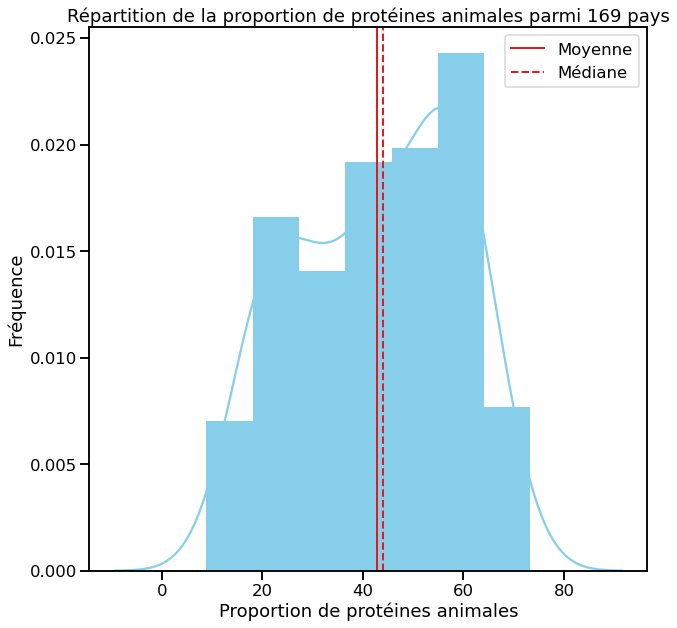

In [15]:
_ = plt.figure(figsize = (10,10))

_ = sns.distplot(df['prot_anim_prot_tot'],
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15, 'alpha':1})
_ = plt.axvline(x=df['prot_anim_prot_tot'].mean(), label='Moyenne', linestyle='-', linewidth=2)
_ = plt.axvline(x=df['prot_anim_prot_tot'].median(), label='Médiane', linestyle='--', linewidth=2)
_ = plt.xlabel('Proportion de protéines animales')
_ = plt.ylabel('Fréquence')
_ = plt.title('Répartition de la proportion de protéines animales parmi 169 pays')
_ = plt.legend()

_ = plt.savefig('Distribution_prop_prot')

_ = plt.show()

Une fois la distribution représentée, on effectue un test statistique pour vérifier que l'adéquation de nos données est significative ou non. 

In [16]:
ks_2samp(df["prot_anim_prot_tot"],list(np.random.normal(np.mean(df["prot_anim_prot_tot"]), np.std(df["prot_anim_prot_tot"]), 1000)))

KstestResult(statistic=0.09705882352941177, pvalue=0.12035076842761472)

On obtient une valeur D = 0.08. Selon la table de Kolmogorov-Smirnov pour un échantillon N = 169 et un coefficient $\alpha =$ 0.05, on obtient 1.358$\div\sqrt169 =$ 0.10. On ne peut pas rejeter l'hypothèse nulle (H$_0$) à un coefficient $\alpha =$ 5%. La distribution de la proportion de protéine animale suit une loi normale. 

*Source : https://lemakistatheux.wordpress.com/2013/05/09/le-test-de-kolmogorov-smirnov/*

### 2.2. Adéquation à une loi statistique de la variable : *Croissance de la population*

On s'intéresse ensuite à l'adéquation de la distribution de la croissance de population à la loi normale. On aura donc une hypothèse nulle (H$_0$) où la croissance de population suit une loi normale. L'hypothèse alternative (H$_1$) indique que notre variable d'intérêt ne suit pas la loi normale.

  \begin{cases}
    H_0      & \quad \text{F} = \text{F}_0\\
    H_1      & \quad \text{F} \neq\ \text{F}_0
  \end{cases}

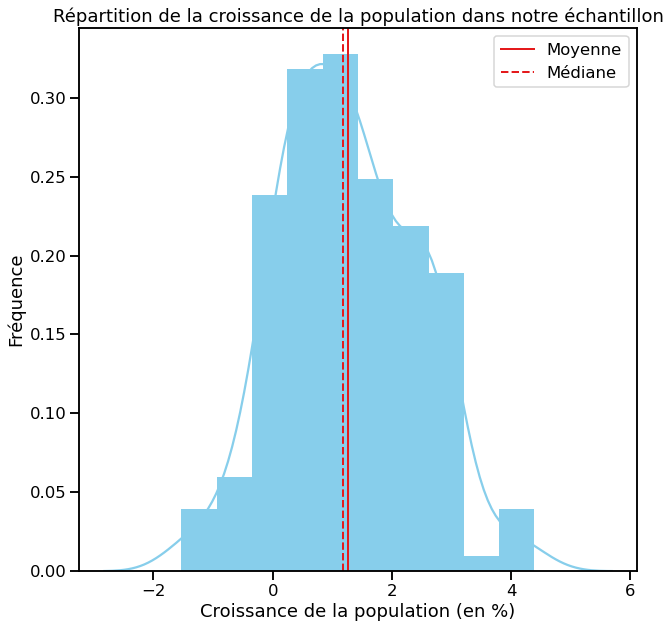

In [17]:
_ = plt.figure(figsize = (10,10))

_ = sns.distplot(df["croissance_pop"],
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
_ = plt.axvline(x=df["croissance_pop"].mean(), label='Moyenne', linestyle='-', linewidth=2)
_ = plt.axvline(x=df["croissance_pop"].median(), label='Médiane', linestyle='--', linewidth=2)
_ = plt.xlabel('Croissance de la population (en %)')
_ = plt.ylabel('Fréquence')
_ = plt.title('Répartition de la croissance de la population dans notre échantillon')
_ = plt.legend()

_ = plt.savefig('Distribution_croissance_pop')

_ = plt.show()

La distribution de la croissance annuelle de la population semble suivre la loi statistique normale. On va donc vérifier cela à l'aide d'un test. 

In [18]:
ks_2samp(df["croissance_pop"],list(np.random.normal(np.mean(df["croissance_pop"]), np.std(df["croissance_pop"]), 1000)))

KstestResult(statistic=0.07252941176470588, pvalue=0.40774266094697686)

On obtient une valeur D = 0.07. Selon la table de Kolmogorov-Smirnov pour un échantillon N = 169 et un coefficient $\alpha =$ 0.05, on obtient 1.358$\div\sqrt169 =$ 0.10. On ne peut donc pas rejeter l'hypothèse nulle (H$_0$) à un coefficient $\alpha =$ 5%. La distribution de la croissance de la population suit donc la loi normale. 

### 2.3. Adéquation à une loi statistique de la variable : *Disponibilité alimentaire en protéines par habitant*

Notre troisième test s'intéresse à la distribution de la disponibilité alimentaire en protéines par habitant dans nos 169 pays. L'hypothèse nulle (H$_0$) correspond à une adéquation de la distribution à une loi normale alors que l'hypothèse alternative (H$_1$) correspond à une non-adéquation à la loi normale. 

  \begin{cases}
    H_0      & \quad \text{F} = \text{F}_0\\
    H_1      & \quad \text{F} \neq\ \text{F}_0
  \end{cases}

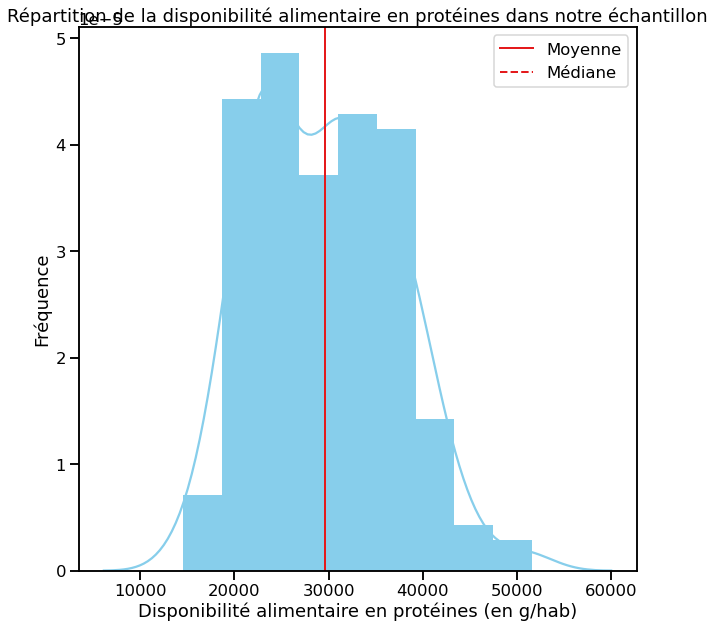

In [19]:
_ = plt.figure(figsize = (10,10))

_ = sns.distplot(df["dispo_prot_hab"],
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
_ = plt.axvline(x=df["dispo_prot_hab"].mean(), label='Moyenne', linestyle='-', linewidth=2)
_ = plt.axvline(x=df["dispo_prot_hab"].median(), label='Médiane', linestyle='--', linewidth=2)
_ = plt.xlabel('Disponibilité alimentaire en protéines (en g/hab)')
_ = plt.ylabel('Fréquence')
_ = plt.title('Répartition de la disponibilité alimentaire en protéines dans notre échantillon')
_ = plt.legend()

_ = plt.savefig('Distribution_prot')

_ = plt.show()

Graphiquement, il semblerait que la disponibilité alimentaire en protéines suit la loi normale. Nous allons vérifier cette observation à l'aide d'un test statistique.

In [20]:
ks_2samp(df["dispo_prot_hab"],list(np.random.normal(np.mean(df["dispo_prot_hab"]), np.std(df["dispo_prot_hab"]), 1000)))

KstestResult(statistic=0.10817647058823529, pvalue=0.06141038193838144)

On obtient une valeur D = 0.10. Selon la table de Kolmogorov-Smirnov pour un échantillon N = 169 et un coefficient $\alpha =$ 0.05, on obtient 1.358$\div\sqrt169 =$ 0.10. On ne peut pas rejeter l'hypothèse nulle (H$_0$) à un coefficient $\alpha =$ 5%. On peut donc dire que la disponibilité alimentaire en protéines par habitant suit la loi normale. 

### 2.4. Adéquation à une loi statistique de la variable : *Disponibilité alimentaire en calories par habitant*

Notre quatrième test s'intéresse à la distribution de la disponibilité alimentaire en calories par habitant. L'hypothèse nulle (H$_0$) correspond à une adéquation de la distribution à une loi normale alors que l'hypothèse alternative (H$_1$) correspond à une non-adéquation à la loi normale. 

  \begin{cases}
    H_0      & \quad \text{F} = \text{F}_0\\
    H_1      & \quad \text{F} \neq\ \text{F}_0
  \end{cases}

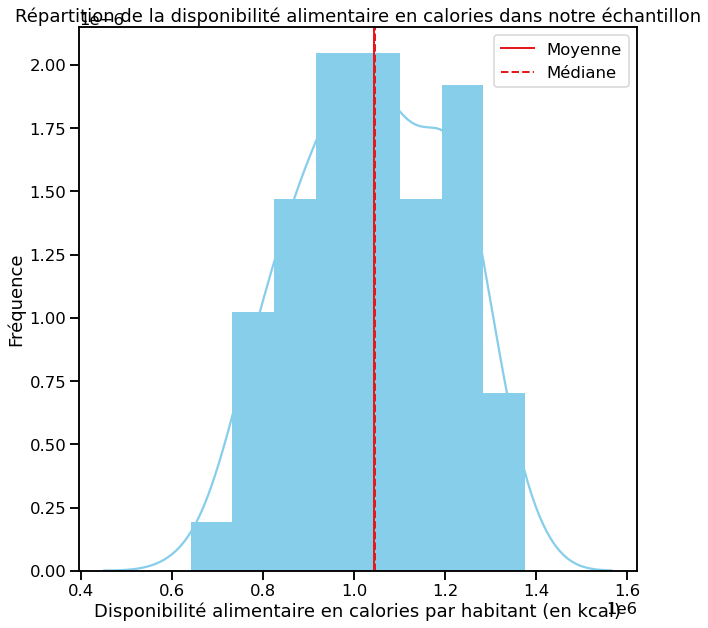

In [21]:
_ = plt.figure(figsize = (10,10))

_ = sns.distplot(df["dispo_kcal_hab"],
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
_ = plt.axvline(x=df["dispo_kcal_hab"].mean(), label='Moyenne', linestyle='-', linewidth=2)
_ = plt.axvline(x=df["dispo_kcal_hab"].median(), label='Médiane', linestyle='--', linewidth=2)
_ = plt.xlabel('Disponibilité alimentaire en calories par habitant (en kcal)')
_ = plt.ylabel('Fréquence')
_ = plt.title('Répartition de la disponibilité alimentaire en calories dans notre échantillon')
_ = plt.legend()

_ = plt.savefig('Distribution_kcal.jpg')

_ = plt.show()

Dans ce cas, on observe que la distribution de la disponibilité alimentaire en calories semble suivre une loi normale. 

In [22]:
ks_2samp(df["dispo_kcal_hab"],list(np.random.normal(np.mean(df["dispo_kcal_hab"]), np.std(df["dispo_kcal_hab"]), 1000)))

KstestResult(statistic=0.07958823529411764, pvalue=0.29840727796493727)

On obtient une valeur D = 0.06. Selon la table de Kolmogorov-Smirnov pour un échantillon N = 169 et un coefficient $\alpha =$ 0.05, on obtient 1.358$\div\sqrt169 =$ 0.10. On ne peut donc pas rejeter l'hypothèse nulle (H$_0$) à un coefficient $\alpha =$ 5%. La distribution de la disponibilité alimentaire en calories par habitant suit donc la loi normale. 

## 3. Classification hiérarchique : le dendrogramme

La prochaine étape de notre étude va être de classer nos 169 pays en 5 groupes en utilisant les indices calculés plus tôt. On commence par modifier notre DataFrame pour que cela ne pose pas de problème lors de la classification hiérarchique.

In [23]:
# On paramètre l'index pour qu'il se base sur la colonne "pays"
df = df.set_index('pays')
df.head()

,prot_anim_prot_tot,croissance_pop,dispo_prot_hab,dispo_kcal_hab
pays,,,,
Arménie,45.78,0.29,35525.45,1121280.0
Afghanistan,19.52,2.58,19742.85,728905.0
Albanie,55.50,-0.08,43617.50,1241000.0
Algérie,27.68,2.07,33890.25,1220925.0
Angola,30.45,3.38,19742.85,827090.0


Une fois cela fait, on peut commencer à créer notre dendrogramme pour obtenir nos cinq groupes (ou clusters). On utilise la méthode du saut de Ward comme paramètre de notre classification.

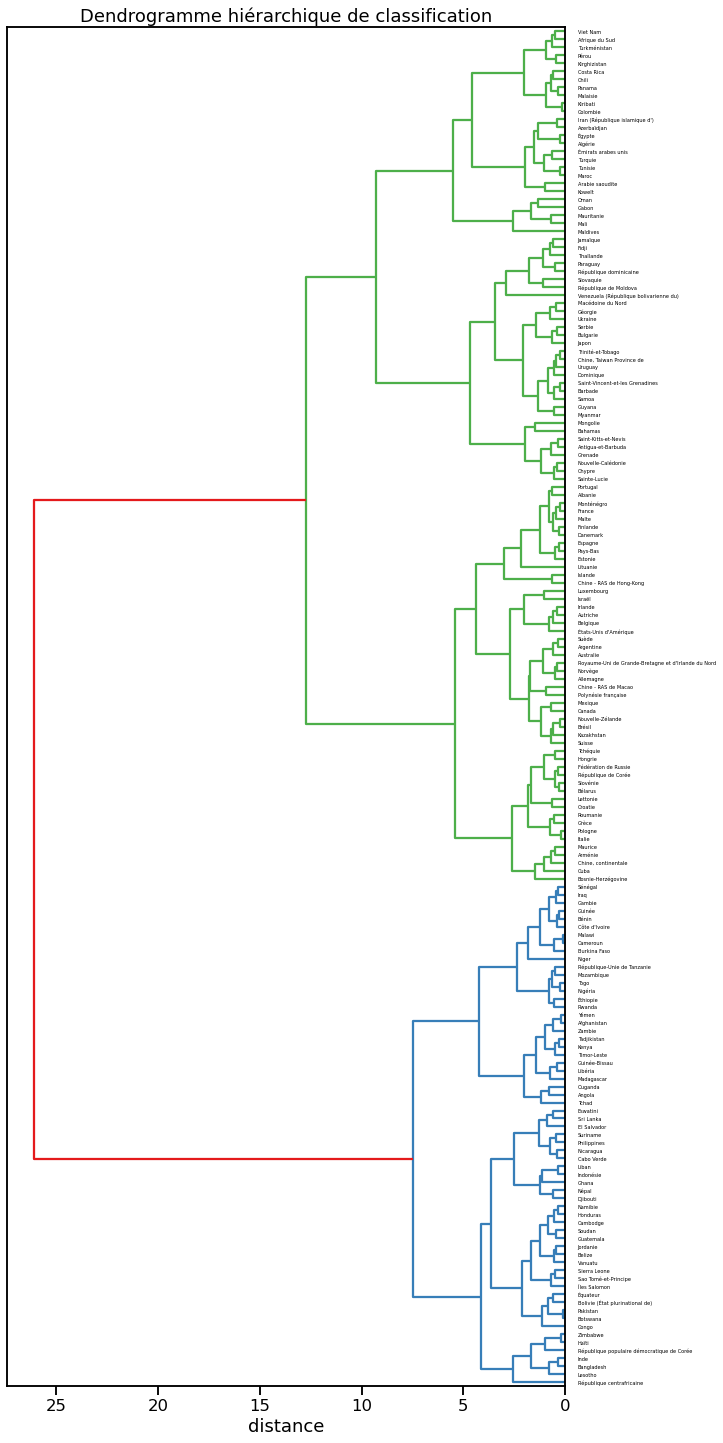

In [24]:
# préparation des données pour le clustering
X = df.values
names = df.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plt.figure(figsize=(10,25))
_ = dendrogram(Z,
        labels = names,
        orientation = "left")
_ = plt.title('Dendrogramme hiérarchique de classification')
_ = plt.xlabel('distance')
_ = plt.savefig('P5_01_dendrogramme.jpg')

_ = plt.show()

In [25]:
# On récupère les données du dendrogramme
# puis on crée un DataFrame avec la liste des pays associée à leur cluster

cluster = fcluster(Z, t=5, criterion='maxclust')
data_cluster = pd.DataFrame({'pays' : df.index.tolist(),
                             'ddg_cluster' : cluster})
data_cluster = data_cluster.sort_values(['ddg_cluster', 'pays'])
data_cluster.to_csv('P5_03_listepays.csv')

A la suite de la création de notre dendrogramme, on obtient une liste de pays à laquelle on a attribué un groupe. Les caractéristiques de ces groupes seront détaillées plus bas.

## 4. Analyse en composantes principales

Une fois la liste de pays créée, on peut passer à l'analyse en composantes principales. Grâce à cette dernière, on pourra définir des composantes dans laquelle nos pays évoluent et ensuite créer un nuage de points contenant le placement de nos pays en fonction des composantes créées plus tôt. 

In [26]:
# On crée les différents composants nécessaires à l'ACP
n_comp = 4
data_pca = df[['croissance_pop', 'prot_anim_prot_tot', 'dispo_prot_hab', 'dispo_kcal_hab']]

X = df.values
names = df.index
features = df.columns

In [27]:
# On prépare les données en faisant une normalisation (centrage-réduction)
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [28]:
# On applique l'ACP sur nos données transformées
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=4)

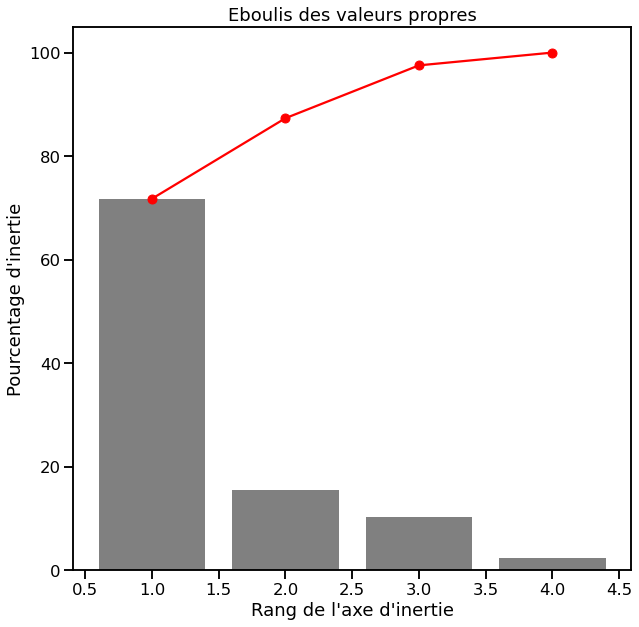

In [29]:
# On affiche l'éboulis des valeurs propres
# On pourra voir le pourcentage d'inertie pour chaque composante

fig, ax = plt.subplots(figsize=(10,10))
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree, color='gray')
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o', color='r')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Selon le critère de Kaiser, on garde les composantes qui représentent (100/p) avec p = 4 $(100\div4) = 25$. L'étude des éboulis des valeurs propres montre une composante F1 expliquant 71.8% de l'intertie et une composante F2 expliquant 15.6%. Il faut minimum deux composantes pour représenter un plan, on va donc conserver deux composantes et l'on étudiera le premier plan de l'analyse en composante principale.

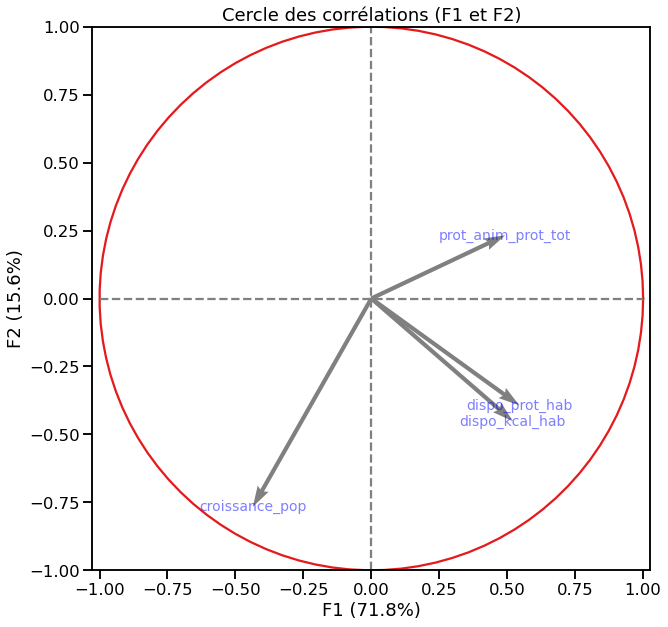

In [30]:
pcs = pca.components_

# On affiche le cercle des corrélations du premier plan avec les composantes F1 et F2
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

Les variables concernant la disponibilité alimentaire en protéines et en calories par habitant et la proportion en protéines animales varient beaucoup sur la composante F1. On peut donc interpréter la composante F1 comme reflétant les informations en lien avec la nutrition. La croissance démographique de la population varie énormémement sur la composante F2. On peut donc dire que la composante F2 donne des informations sur la démographie du pays.

On ajoute les clusters crées plus tôt pour pouvoir placer les pays sur les deux composantes de notre analyse. 

In [31]:
df = pd.merge(df, data_cluster, on='pays')
illustrative_var = df['ddg_cluster']
df = df.set_index('pays')

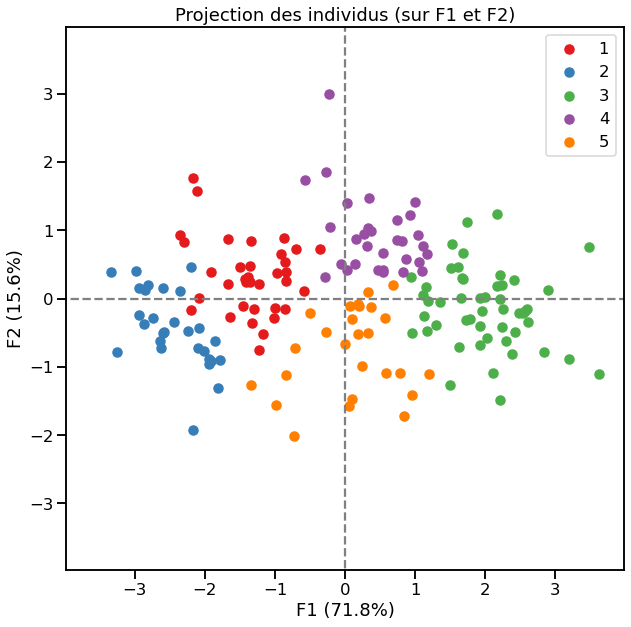

In [32]:
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=illustrative_var)

Nos cinq groupes se répartissent sur les deux composantes de notre analyse factorielle. Il semblerait qu'à ce stade, on ne puisse prendre qu'une seule décision : exclure les pays du cluster 3. En effet, il s'agit du seul cluster où les pays ont une croissance démographique plutôt stable et une disponibilité alimentaire plutôt bonne. 

Pour confirmer cela, on peut faire une projection des centroïdes de nos clusters sur nos deux composantes. 

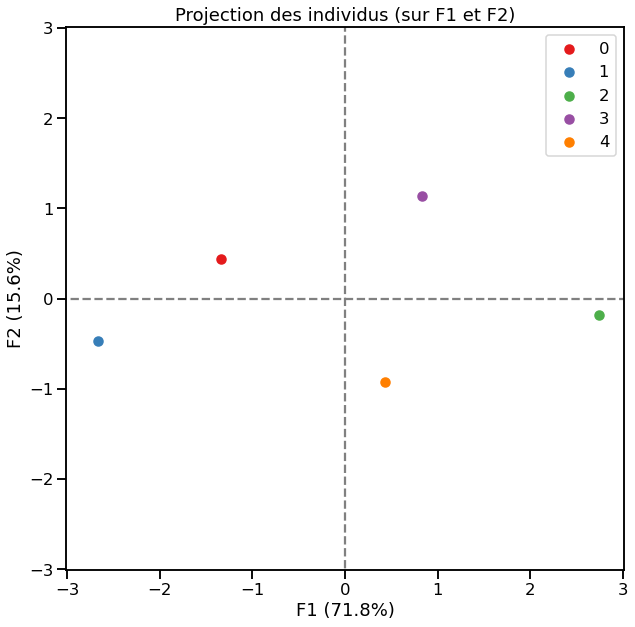

In [33]:
df2 = df.groupby('ddg_cluster').mean().reset_index()
df2 = df2.drop(columns='ddg_cluster')
#df2 = df2.set_index('ddg_cluster')

X = df2.values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Projection des points dans le premier plan factoriel
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=df2.index)

In [34]:
# Position des centroïdes
coor_centroids = pd.DataFrame(X_scaled, columns=df2.columns, index=df2.index)
coor_centroids.to_csv('P5_04_coordonneescentroides.csv')

Enfin, on vérifie que les pays sont répartis équitablement dans les clusters. 

In [35]:
df['ddg_cluster'].value_counts()

3    50
1    35
4    31
2    28
5    26
Name: ddg_cluster, dtype: int64

On dénombre le nombre de pays dans chacun de nos clusters pour voir s'ils se distribuent de manière équivalente. On observe un cluster 3 contenant 50 pays mais ce cluster ne contient pas de pays pouvant être une bonne cible pour lancer notre nouveau marché. On peut laisser cette répartition ainsi et faire notre analyse statistique sur les quatre clusters de pays restant.

## 5. Comparaison de moyennes entre deux clusters

On crée une table qui contient les caractéristiques de chacun de nos clusters. 

In [36]:
df_2 = pd.pivot_table(df, columns='ddg_cluster', aggfunc=np.mean).transpose()
df_2 = df_2[['croissance_pop', 'prot_anim_prot_tot', 'dispo_kcal_hab', 'dispo_prot_hab']]
df_2

,croissance_pop,prot_anim_prot_tot,dispo_kcal_hab,dispo_prot_hab
ddg_cluster,,,,
1,1.592000,31.944000,9.143250e+05,22928.257143
2,2.797143,20.272143,8.581280e+05,21619.080357
3,0.389400,57.528400,1.225597e+06,38187.395000
4,0.370323,52.818710,1.001548e+06,28540.056452
5,1.931538,41.537308,1.110765e+06,31956.030769


Dans cette partie, on va réaliser des statistiques inférentielles pour définir la significativité de nos données. On va s'intéresser aux clusters 1 et 2.
En effet, ces deux clusters se caractérisent par de faibles disponibilités alimentaires et une croissance de la population importante. Il aurait pu être aussi intéressant de comparer les clusters 1 et 4.

#### 5.1. Comparaison de moyennes pour la proportion de protéines animales

On commence par représenter graphiquement les proportions de protéines animales dans chacun de nos clusters. 

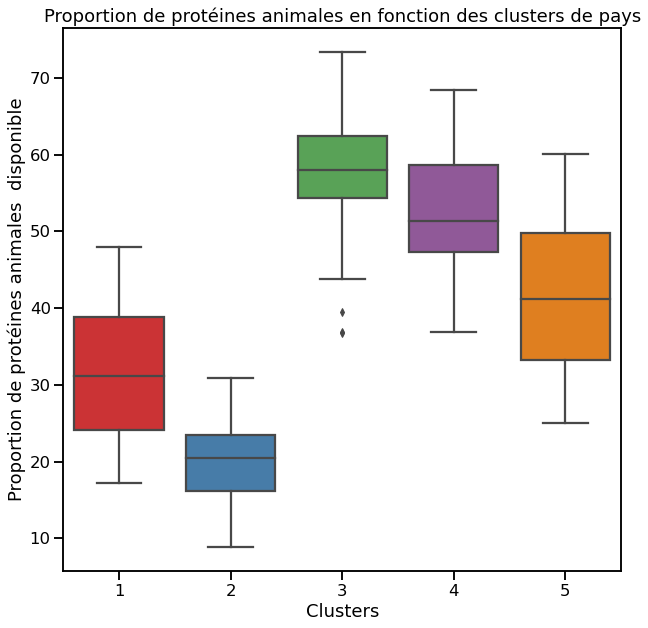

In [37]:
plt.figure(figsize=(10,10))

_ = sns.boxplot(x='ddg_cluster', y='prot_anim_prot_tot', data=df)
_ = plt.xlabel('Clusters')
_ = plt.ylabel('Proportion de protéines animales  disponible')
_ = plt.title('Proportion de protéines animales en fonction des clusters de pays')

_ = plt.savefig('boxplot_prop_prot.jpg')

_ = plt.show()

On commence par vérifier si la condition d'égalité des variances est vérifiée pour la proportion de protéines animales. On aura donc une hypothèse nulle (H$_0$) où la variance dans le cluster 1 et la variance dans le cluster 2 sera identique et une hypothèse alternative (H$_1$) où nos deux variances seront différentes.

  \begin{cases}
    H_0      & \quad \sigma^2_1 = \sigma^2_2\\
    H_1      & \quad \sigma^2_1 \neq\ \sigma^2_2
  \end{cases}

In [38]:
clust1 = df[df["ddg_cluster"]==1]["prot_anim_prot_tot"]
clust2 = df[df["ddg_cluster"]==2]["prot_anim_prot_tot"]
st.stats.bartlett(clust1,clust2)

BartlettResult(statistic=7.2534848553803215, pvalue=0.007076355175896707)

Avec une p-value = 0.007, on peut rejeter l'hypothèse nulle (H$_0$). Nos variances ne sont donc pas égales. On effectuera un test de Welsch avec les hypothèses suivantes :

  \begin{cases}
    H_0      & \quad \mu^2_1 = \mu^2_2\\
    H_1      & \quad \mu^2_1 \neq\ \mu^2_2
  \end{cases}

In [39]:
st.stats.ttest_ind(clust1,clust2, equal_var=False)

Ttest_indResult(statistic=6.589288206131637, pvalue=1.5484791165115913e-08)

La p-value de notre test est égale à $1.55^-8$. On peut donc rejeter l'hypothèse nulle (H$_0$). La proportion de protéines animales dans le cluster 1 et le cluster 2 est donc différente.

#### 5.2. Comparaisons de moyennes pour la croissance de la population

On représente graphiquement les données en lien avec la croissance de la population pour chacun de nos clusters. 

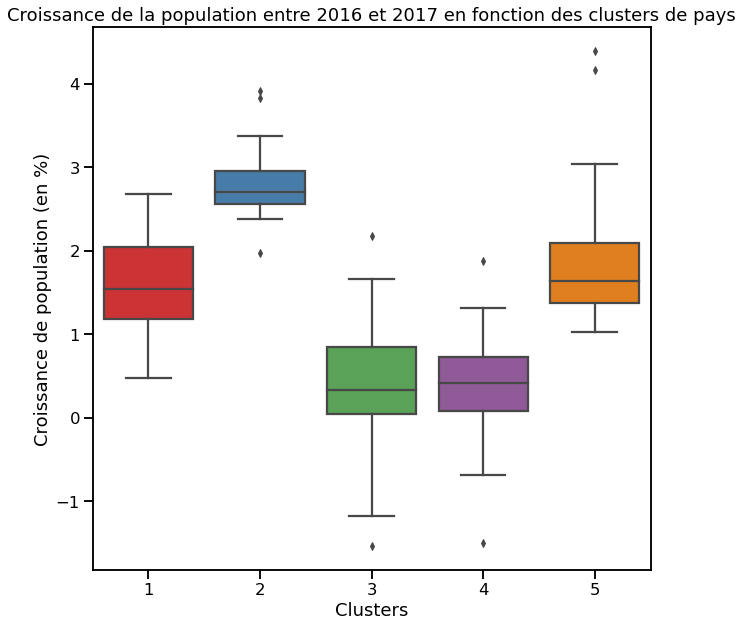

In [40]:
plt.figure(figsize=(10,10))

_ = sns.boxplot(x='ddg_cluster', y='croissance_pop', data=df)
_ = plt.xlabel('Clusters')
_ = plt.ylabel('Croissance de population (en %)')
_ = plt.title('Croissance de la population entre 2016 et 2017 en fonction des clusters de pays')

_ = plt.savefig('Boxplot_croissance')

_ = plt.show()

Ensuite, on vérifie si la condition d'égalité des variances est vérifiée pour la croissance de la population. On aura donc une hypothèse nulle (H$_0$) où la variance dans le cluster 1 et la variance dans le cluster 2 sera identique et une hypothèse alternative (H$_1$) où nos deux variances seront différentes.

  \begin{cases}
    H_0      & \quad \sigma^2_1 = \sigma^2_2\\
    H_1      & \quad \sigma^2_1 \neq\ \sigma^2_2
  \end{cases}

In [41]:
clust1 = df[df["ddg_cluster"]==1]["croissance_pop"]
clust2 = df[df["ddg_cluster"]==2]["croissance_pop"]
st.stats.bartlett(clust1,clust2)

BartlettResult(statistic=4.6019239378453225, pvalue=0.031936097802139456)

Avec une p-value de 0.03, on peut rejeter l'hypothèse nulle (H$_0$). On peut donc conclure que l'on n'a pas d'égalité des variances pour le cluster 1 et 2. On effectue ensuite un test de Welsch avec les hypothèses suivantes : 

  \begin{cases}
    H_0      & \quad \mu^2_1 = \mu^2_2\\
    H_1      & \quad \mu^2_1 \neq\ \mu^2_2
  \end{cases}

In [42]:
st.stats.ttest_ind(clust1,clust2, equal_var=False)

Ttest_indResult(statistic=-9.385909521647417, pvalue=2.5121909757602825e-13)

Le test t de comparaison de moyenne obtient une p-value de 2.51$^-13$. On peut donc rejeter l'hypothèse d'égalité H$_0$. La moyenne de la croissance de population entre le cluster 1 et le cluster 2 est différente.

#### 5.3. Comparaisons de moyennes pour la disponibilité alimentaire par habitant

Avant de faire le calcul de comparaison de moyenne pour la disponibilité en protéines annuelles par habitant, on calcule la corrélation entre la disponibilité en protéines et la disponibilité en calories. En effet, il existe un lien entre les protéines et les calories. Si cette corrélation est importante, on peut se contenter de faire uniquement la comparaison de moyenne pour les protéines. 

In [43]:
x = df['dispo_prot_hab']
y = df['dispo_kcal_hab']

print('rho de pearson :', st.stats.pearsonr(x, y)[0])
print('indice de covariation :', np.cov(x, y, ddof=0)[1,0])

Y = df['dispo_kcal_hab']
X = df[['dispo_prot_hab']]
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()
a,b = result.params['dispo_prot_hab'],result.params['intercept']
print('r-squared : ', (st.stats.pearsonr(x,y)[0])**2)

rho de pearson : 0.8788394301036588
indice de covariation : 1079153667.7352073
r-squared :  0.7723587439049239


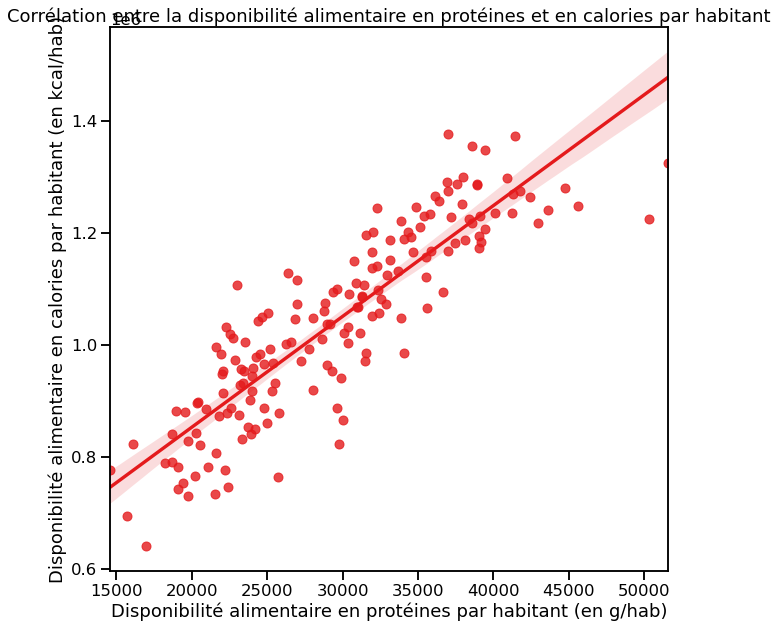

In [44]:
_ = plt.figure(figsize = (10,10))
_ = sns.regplot('dispo_prot_hab', 'dispo_kcal_hab', data=df)
_ = plt.xlabel("Disponibilité alimentaire en protéines par habitant (en g/hab)")
_ = plt.ylabel("Disponibilité alimentaire en calories par habitant (en kcal/hab)")
_ = plt.title("Corrélation entre la disponibilité alimentaire en protéines et en calories par habitant")

_ = plt.savefig('Reglin_prot_kcal.jpg')

_ = plt.show()

Avec un coefficient de Pearson $\rho = $0.87 et un R² de 0.77, on a une corrélation linéaire positive forte entre la disponibilité alimentaire en protéines et la disponibilité alimentaire en calories. 

La disponibilité de protéines par habitant suit la loi normale. On va donc effectuer le reste de notre analyse sur cette donnée.

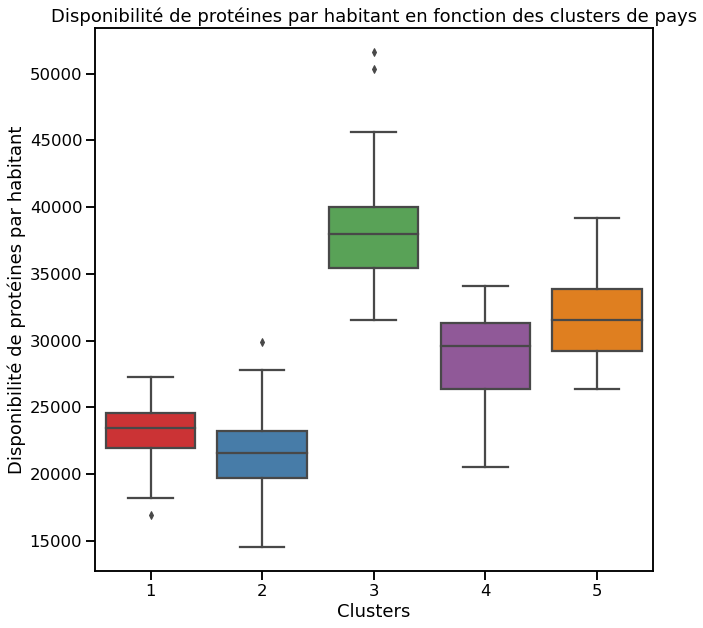

In [45]:
plt.figure(figsize=(10,10))

_ = sns.boxplot(x='ddg_cluster', y='dispo_prot_hab', data=df)
_ = plt.xlabel('Clusters')
_ = plt.ylabel('Disponibilité de protéines par habitant')
_ = plt.title('Disponibilité de protéines par habitant en fonction des clusters de pays')

_ = plt.savefig('Boxplot_prot')

_ = plt.show()

On effectue ensuite un test de Bartlett pour évaluer la variance de nos deux variables dans nos deux échantillons. On aura donc les hypothèses suivantes : 

  \begin{cases}
    H_0      & \quad \sigma^2_1 = \sigma^2_2\\
    H_1      & \quad \sigma^2_1 \neq\ \sigma^2_2
  \end{cases}

In [46]:
clust1 = df[df["ddg_cluster"]==1]["dispo_prot_hab"]
clust2 = df[df["ddg_cluster"]==2]["dispo_prot_hab"]
st.stats.bartlett(clust1,clust2)

BartlettResult(statistic=2.6865897545148987, pvalue=0.10119618630809747)

Avec une p-value de 0.10, on ne peut pas rejeter l'hypothèse d'égalité des variances. On peut donc effectuer un test t de Student de comparaison de moyennes avec les hypothèses suivantes : 

  \begin{cases}
    H_0      & \quad \mu^2_1 = \mu^2_2\\
    H_1      & \quad \mu^2_1 \neq\ \mu^2_2
  \end{cases}

In [47]:
st.stats.ttest_ind(clust1,clust2, equal_var=True)

Ttest_indResult(statistic=1.7700311044065205, pvalue=0.08171931016117341)

Avec une p-value de 0.08, on ne peut pas rejeter l'hypothèse nulle. La moyenne de la disponibilité en protéines pour le cluster 1 et le cluster 2 est égale.

## 6. Deuxième étude de marché

Dans cette deuxième étude, nous allons nous concentrer uniquement sur les pays des clusters 1, 2 et 4 que nous avons retenu au préalable.

In [48]:
data = df.loc[(df['ddg_cluster']==1) | (df['ddg_cluster']==2) | (df['ddg_cluster']==3) | (df['ddg_cluster']==4)]
data.head()

,prot_anim_prot_tot,croissance_pop,dispo_prot_hab,dispo_kcal_hab,ddg_cluster
pays,,,,,
Arménie,45.78,0.29,35525.45,1121280.0,3
Afghanistan,19.52,2.58,19742.85,728905.0,2
Albanie,55.50,-0.08,43617.50,1241000.0,3
Angola,30.45,3.38,19742.85,827090.0,2
Antigua-et-Barbuda,66.61,0.95,29619.75,886585.0,4


In [49]:
data.shape

(144, 5)

### 6.1. Création de la variable PIB

On ajoute la variable PIB que l'on a trouvé dans les données du site de la FAO. Cette valeur nous servira d'indicateur de la santé économique de nos pays.

In [50]:
eco = pd.read_csv('C:/Users/cecil/OneDrive/Documents/Formation - Data Analyst/Projets/P5_guillot_cecile/croissance_eco_2017.csv')

In [51]:
eco = eco[['Zone', 'Valeur']]
eco = eco.rename(columns={'Zone' : 'pays',
                          'Valeur' : 'PIB_hab'})
eco.head()

,pays,PIB_hab
0,Afghanistan,2202.6
1,Afrique du Sud,12703.4
2,Albanie,13037.0
3,Algérie,11550.5
4,Allemagne,53011.8


In [52]:
data = pd.merge(data, eco, on = 'pays')
data = data.drop(columns='ddg_cluster')
data.head()

,pays,prot_anim_prot_tot,croissance_pop,dispo_prot_hab,dispo_kcal_hab,PIB_hab
0,Arménie,45.78,0.29,35525.45,1121280.0,12115.1
1,Afghanistan,19.52,2.58,19742.85,728905.0,2202.6
2,Albanie,55.50,-0.08,43617.50,1241000.0,13037.0
3,Angola,30.45,3.38,19742.85,827090.0,7310.9
4,Antigua-et-Barbuda,66.61,0.95,29619.75,886585.0,19840.1


In [53]:
del eco

### 6.2. Création d'une variable sur la consommation de viande de volailles

In [54]:
animaux = pd.read_csv('C:/Users/cecil/OneDrive/Documents/Formation - Data Analyst/Projets/P5_guillot_cecile/animaux_2017.csv')

In [55]:
animaux = animaux[animaux['Produit'] == 'Viande de Volailles']
animaux = pd.pivot_table(animaux, index=['Code zone', 'Zone'], columns='Élément', values = 'Valeur', aggfunc=np.sum).reset_index()
animaux.head()

Élément,Code zone,Zone,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure
0,1,Arménie,54.0,16.06,3.39,5.44,47.0
1,2,Afghanistan,5.0,1.53,0.33,0.54,57.0
2,3,Albanie,85.0,16.36,6.45,6.26,47.0
3,4,Algérie,22.0,6.38,1.50,1.97,277.0
4,7,Angola,35.0,10.56,2.22,3.60,319.0


In [56]:
animaux = animaux.rename(columns = {'Zone' : 'pays'})
data = pd.merge(data, animaux, on = 'pays')
data['prot_volaille'] = round((data['Disponibilité de protéines en quantité (g/personne/jour)'] * 365) / data['dispo_prot_hab']*100,2)
data = data[['pays','croissance_pop', 'PIB_hab', 'prot_anim_prot_tot', 'dispo_prot_hab', 'prot_volaille', 'dispo_kcal_hab']]
data = data.set_index('pays')
data = data.fillna(0)
data.head()

,croissance_pop,PIB_hab,prot_anim_prot_tot,dispo_prot_hab,prot_volaille,dispo_kcal_hab
pays,,,,,,
Arménie,0.29,12115.1,45.78,35525.45,5.59,1121280.0
Afghanistan,2.58,2202.6,19.52,19742.85,1.00,728905.0
Albanie,-0.08,13037.0,55.50,43617.50,5.24,1241000.0
Angola,3.38,7310.9,30.45,19742.85,6.66,827090.0
Antigua-et-Barbuda,0.95,19840.1,66.61,29619.75,21.90,886585.0


In [57]:
del animaux

On obtient donc un nouveau DataFrame avec des informations complémentaires pour notre étude. Deux nouvelles variables ont donc été ajouté pour réaliser une nouvelle analyse :
- Une variable sur la situation économique du pays : le PIB par habitant ; 
- Une variable sur la proportion de protéines de volailles parmi la disponibilité alimentaire de protéines par pays.

### 6.3. Adéquation à la loi normale de nos deux nouvelles variables

Ensuite, on teste si nos deux variables suivent la loi normale pour pouvoir les ajouter dans notre nouvelle analyse. 

#### 6.3.1. Adéquation à une loi statistique de la variable : *PIB par habitant*

 L'hypothèse nulle (H$_0$) correspond à une adéquation de la distribution à une loi normale alors que l'hypothèse alternative (H$_1$) correspond à une non-adéquation à la loi normale. 

  \begin{cases}
    H_0      & \quad \text{F} = \text{F}_0\\
    H_1      & \quad \text{F} \neq\ \text{F}_0
  \end{cases}

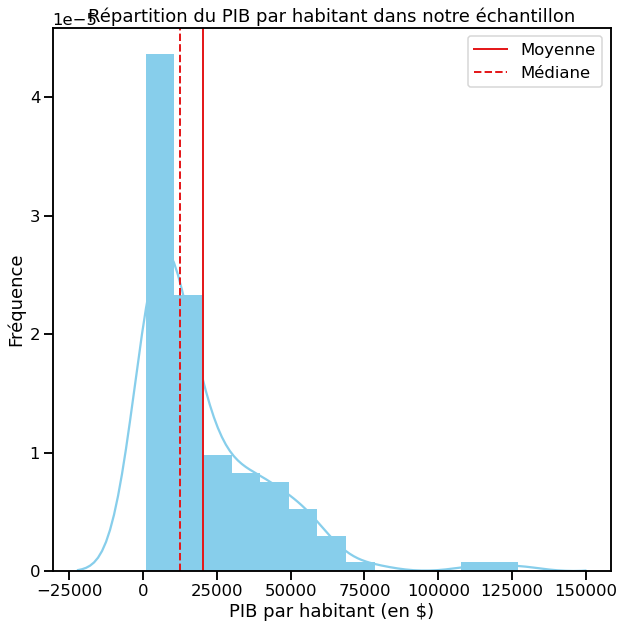

In [58]:
_ = plt.figure(figsize = (10,10))

_ = sns.distplot(data["PIB_hab"],
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
_ = plt.axvline(x=data["PIB_hab"].mean(), label='Moyenne', linestyle='-', linewidth=2)
_ = plt.axvline(x=data["PIB_hab"].median(), label='Médiane', linestyle='--', linewidth=2)
_ = plt.xlabel('PIB par habitant (en $)')
_ = plt.ylabel('Fréquence')
_ = plt.title('Répartition du PIB par habitant dans notre échantillon')
_ = plt.legend()

_ = plt.savefig('Distribution_PIB.jpg')

_ = plt.show()

La représentation graphique indique une distribution qui ne semble pas suivre une loi normale. On va confirmer cela avec un test statistique. 

In [59]:
ks_2samp(data["PIB_hab"],list(np.random.normal(np.mean(data["PIB_hab"]), np.std(data["PIB_hab"]), 1000)))

KstestResult(statistic=0.192, pvalue=0.00022894297339481895)

On obtient une valeur D = 0.18. Selon la table de Kolmogorov-Smirnov pour un échantillon N = 144 et un coefficient $\alpha$ = 0.05, on obtient 1.358$\div\sqrt144 =$ 0.11. On rejette l'hypothèse nulle (H$_0$) à un coefficient $\alpha = $ 5%. La distribution du PIB par habitant ne suit pas la loi normale.

#### 6.3.2. Adéquation à une loi statistique de la variable : *Proportion de protéines de volailles*

L'hypothèse nulle (H$_0$) correspond à une adéquation de la distribution à une loi normale alors que l'hypothèse alternative (H$_1$) correspond à une non-adéquation à la loi normale. 

  \begin{cases}
    H_0      & \quad \text{F} = \text{F}_0\\
    H_1      & \quad \text{F} \neq\ \text{F}_0
  \end{cases}

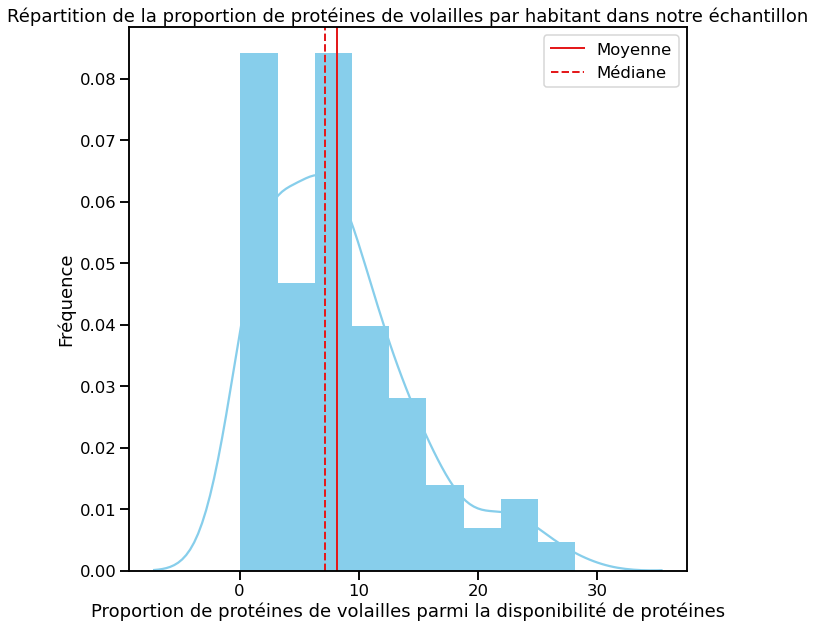

In [60]:
_ = plt.figure(figsize = (10,10))

_ = sns.distplot(data["prot_volaille"],
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
_ = plt.axvline(x=data["prot_volaille"].mean(), label='Moyenne', linestyle='-', linewidth=2)
_ = plt.axvline(x=data["prot_volaille"].median(), label='Médiane', linestyle='--', linewidth=2)
_ = plt.xlabel('Proportion de protéines de volailles parmi la disponibilité de protéines')
_ = plt.ylabel('Fréquence')
_ = plt.title('Répartition de la proportion de protéines de volailles par habitant dans notre échantillon')
_ = plt.legend()

_ = plt.savefig('Distribution_prot_volaille.jpg')

_ = plt.show()

Selon la représentation graphique, il semblerait que la proportion de protéines de volailles suivent une loi normale.

In [61]:
ks_2samp(data["prot_volaille"],list(np.random.normal(np.mean(data["prot_volaille"]), np.std(data["prot_volaille"]), 1000)))

KstestResult(statistic=0.10563503649635037, pvalue=0.1255571590430251)

On obtient une valeur D = 0.09. Selon la table de Kolmogorov-Smirnov pour un échantillon N = 144 et un coefficient $\alpha =$ 0.05, on obtient 1.358$\div\sqrt144 =$ 0.11. On ne peut donc pas rejeter l'hypothèse nulle (H$_0$) à un coefficient $\alpha =$ 5%. La proportion de protéines issues de viandes de volaille par habitant suit donc la loi normale. 

#### 6.3.4. Conclusion

Selon nos analyses, la distribution de la proportion de protéines issues de la viande de volaille suit la loi normale alors que la distribution du PIB par habitant ne suit pas la loi normale.

### 6.4. Clustering par une méthode de classification non-supervisée : le K-Means

1 : 148596.54241462128
2 : 74676.7994873474
3 : 53451.50207350922
4 : 44032.32288012617
5 : 36077.53718084706
6 : 29731.23335670814
7 : 27174.748254005393
8 : 24916.090067894464
9 : 23418.01118322469


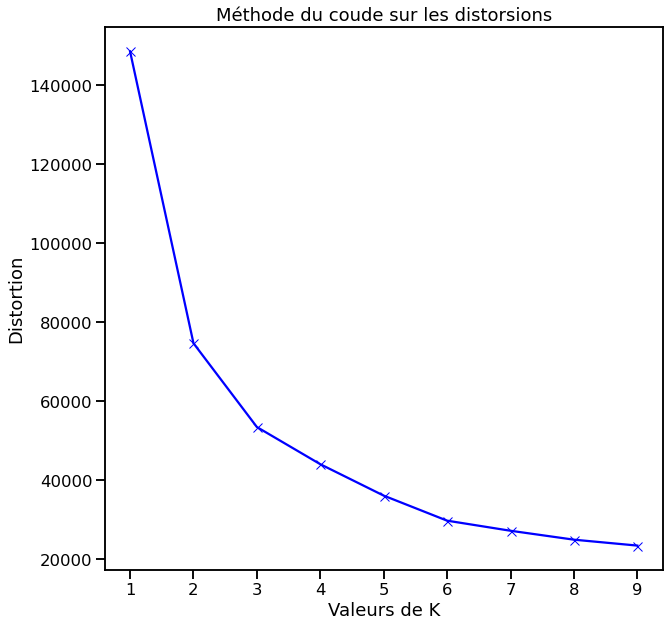

In [62]:
X = data.values

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 


for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

_ = plt.figure(figsize=(10,10))
_ = plt.plot(K, distortions, 'bx-') 
_ = plt.xlabel('Valeurs de K') 
_ = plt.ylabel('Distortion') 
_ = plt.title('Méthode du coude sur les distorsions') 

_ = plt.savefig('Elbow_method.jpg')

_ = plt.show() 

On définit 5 clusters avec la méthode du coude. On va pouvoir utiliser un algorithme du KMeans pour effectuer notre classification.

In [63]:
km = KMeans(n_clusters=5)
km.fit(X)
clusters = km.labels_

In [64]:
data_cluster = pd.DataFrame({'pays' : data.index.tolist(),
                             'kmeans_cluster' : clusters})
data_cluster = data_cluster.sort_values(['kmeans_cluster', 'pays'])
data_cluster

,pays,kmeans_cluster
2,Albanie,0
41,Allemagne,0
7,Autriche,0
132,Belgique,0
19,Canada,0
...,...,...
115,Tadjikistan,4
23,Tchad,4
100,Timor-Leste,4
131,Zambie,4


### 6.5. Analyse par composantes principales (2)

In [65]:
n_comp = 4
data_pca = data[['croissance_pop', 'PIB_hab', 'prot_anim_prot_tot', 'dispo_prot_hab', 'prot_volaille', 'dispo_kcal_hab']]

X = data.values
names = data.index
features = data_pca.columns

In [66]:
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [67]:
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=4)

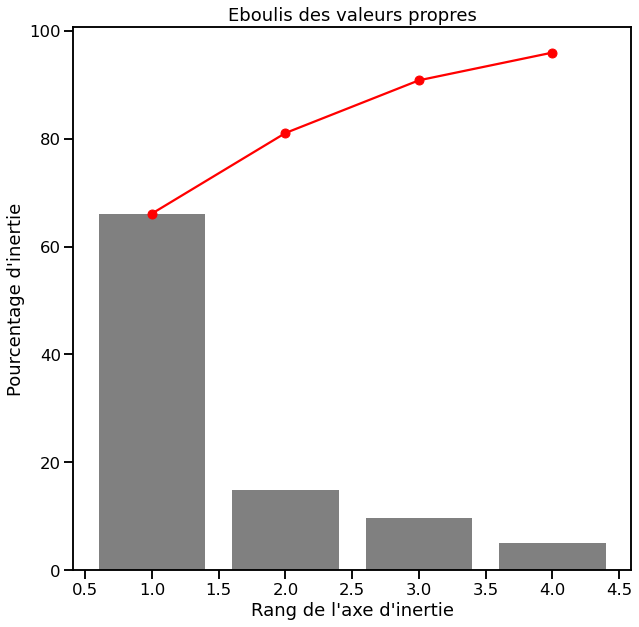

In [68]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set_context('talk')

scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree, color='gray')
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o', color='r')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

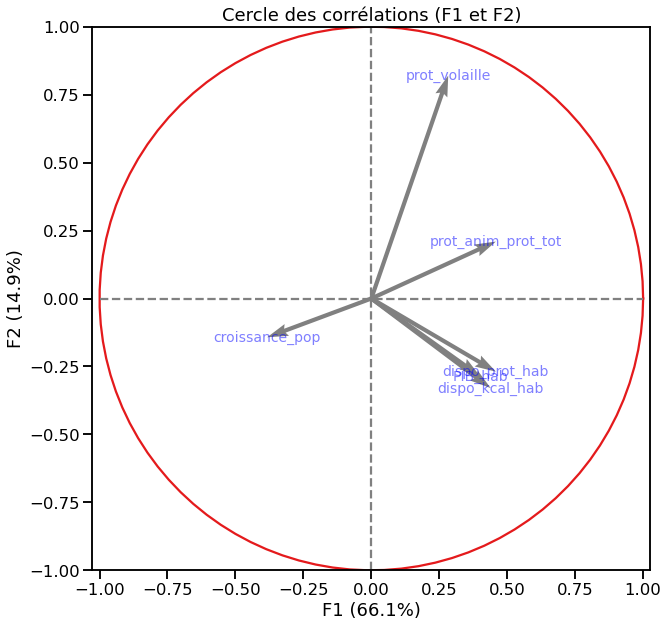

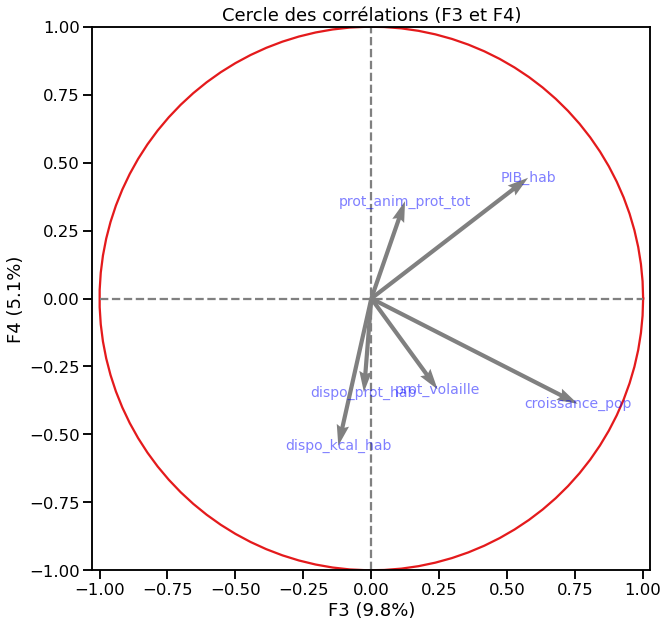

In [69]:
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features))

La composante F1 regroupe les informations sur la disponibilité alimentaire, la composante F2 n'englobe que la proportion de protéines animales issues de viande de volaille et la composante F3 regroupe les variables sur la croissance démographique et le PIB par habitant. 

In [70]:
data = pd.merge(data, data_cluster, on='pays')
illustrative_var = data['kmeans_cluster']
data = data.set_index('pays')
data.head()

,croissance_pop,PIB_hab,prot_anim_prot_tot,dispo_prot_hab,prot_volaille,dispo_kcal_hab,kmeans_cluster
pays,,,,,,,
Arménie,0.29,12115.1,45.78,35525.45,5.59,1121280.0,2
Afghanistan,2.58,2202.6,19.52,19742.85,1.00,728905.0,4
Albanie,-0.08,13037.0,55.50,43617.50,5.24,1241000.0,0
Angola,3.38,7310.9,30.45,19742.85,6.66,827090.0,1
Antigua-et-Barbuda,0.95,19840.1,66.61,29619.75,21.90,886585.0,1


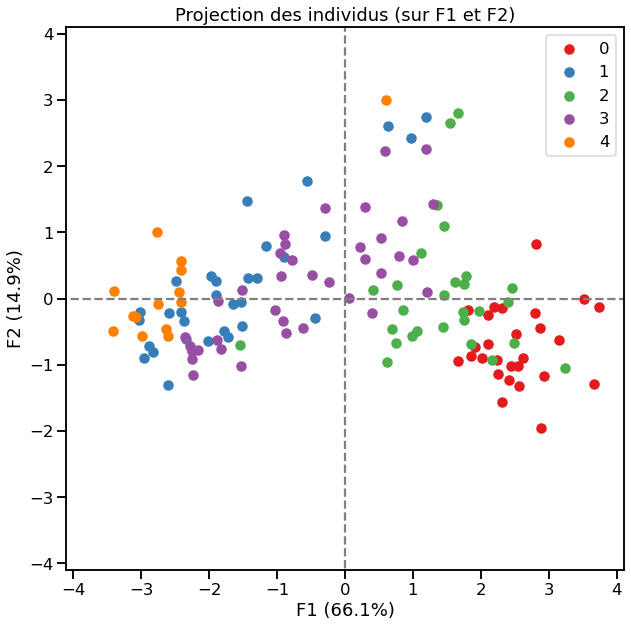

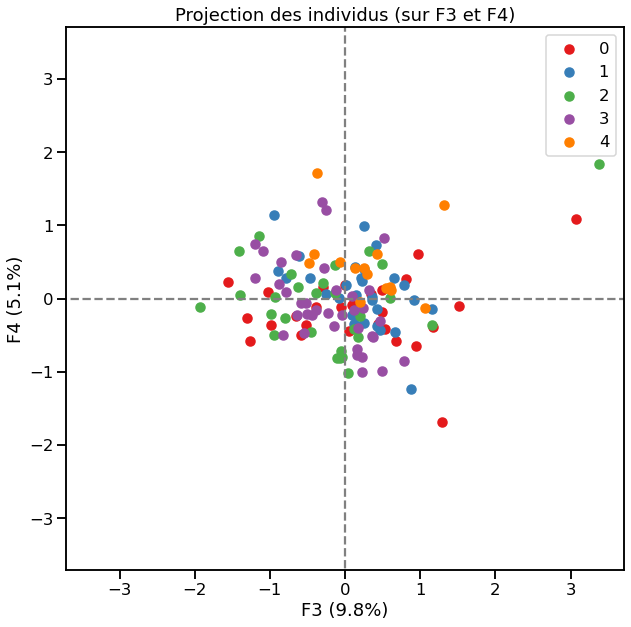

In [71]:
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], illustrative_var=illustrative_var)

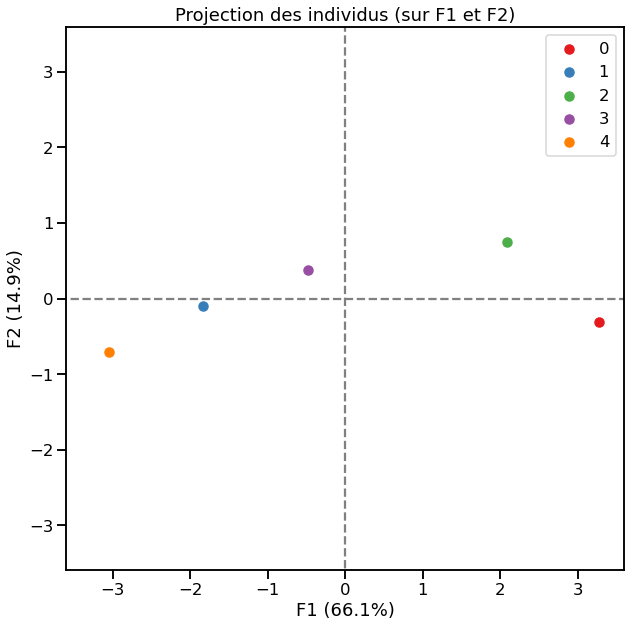

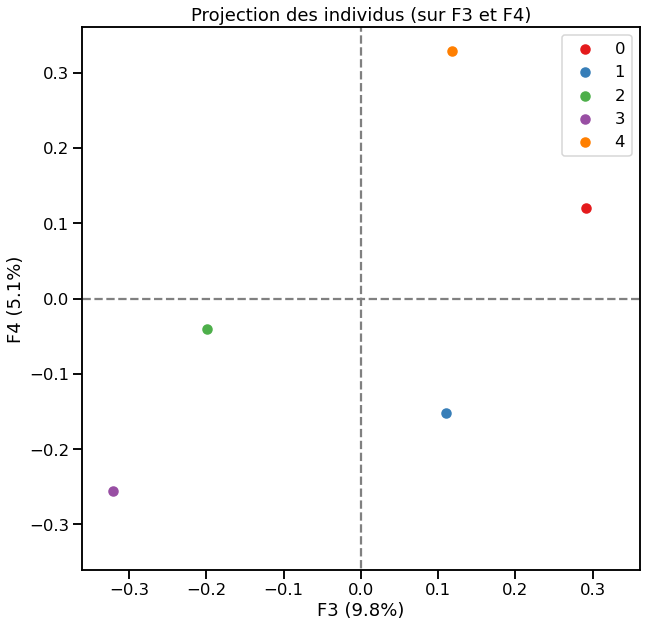

In [72]:
# Calculer la moyenne de chaque variable pour chaque cluster
data2 = pd.pivot_table(data, columns='kmeans_cluster', aggfunc=np.mean).transpose()
data2 = data2[['croissance_pop', 'PIB_hab', 'prot_anim_prot_tot', 'dispo_prot_hab', 'prot_volaille', 'dispo_kcal_hab']]

# Centrer-réduire les valeurs
X2 = data2.values
std_scale2 = preprocessing.StandardScaler().fit(X2)
X_scaled2 = std_scale2.transform(X2)

# Représenter les projections des centroïdes
X_projected2 = pca.transform(X_scaled2)
display_factorial_planes(X_projected2, n_comp, pca, [(0,1),(2,3)], illustrative_var=data2.index)

In [73]:
data['kmeans_cluster'].value_counts()

3    37
1    31
2    28
0    27
4    14
Name: kmeans_cluster, dtype: int64

On observe que les pays sont répartis de manière plutôt homogènes dans nos clusters. Seuls le cluster 4 compte moins de pays que les autres. 

### 6.6. Comparaisons de moyennes entre deux clusters (2)

On crée un DataFrame avec les données récapitulatifs de notre étude. 

In [74]:
data2 = pd.pivot_table(data, columns='kmeans_cluster', aggfunc=np.mean).transpose()
data2 = data2[['croissance_pop', 'PIB_hab', 'prot_anim_prot_tot', 'dispo_prot_hab', 'prot_volaille', 'dispo_kcal_hab']]
data2

,croissance_pop,PIB_hab,prot_anim_prot_tot,dispo_prot_hab,prot_volaille,dispo_kcal_hab
kmeans_cluster,,,,,,
0,0.413333,47113.837037,59.189259,40592.055556,9.549259,1.273782e+06
1,1.996774,7041.325806,33.073548,23243.788710,6.433871,8.816398e+05
2,0.396786,29291.010714,53.695357,34100.907143,10.690000,1.153987e+06
3,1.218649,11594.367568,37.655676,26062.578378,8.334324,1.000919e+06
4,2.312857,4695.671429,27.374286,19836.446429,4.017143,7.553154e+05


On effectue ensuite la comparaison de moyennes entre nos clusters 1 et 3 sur la proportion de protéines issus de la viande de volaille. 

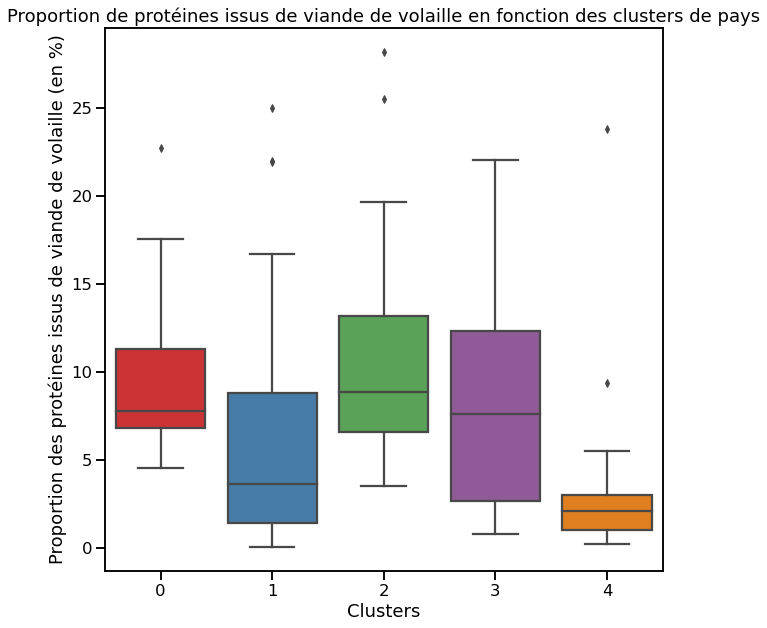

In [75]:
plt.figure(figsize=(10,10))

_ = sns.boxplot(x='kmeans_cluster', y='prot_volaille', data=data)
_ = plt.xlabel('Clusters')
_ = plt.ylabel('Proportion des protéines issus de viande de volaille (en %)')
_ = plt.title('Proportion de protéines issus de viande de volaille en fonction des clusters de pays')

_ = plt.savefig('Boxplot_prot_volaille.jpg')

_ = plt.show()

On commence par vérifier si la condition d'égalité des variances est vérifiée pour la proportion de protéines animales issus de la viande de volaille. On aura donc une hypothèse nulle (H$_0$) où la variance dans le cluster 1 et la variance dans le cluster 3 sera identique et une hypothèse alternative (H$_1$) où nos deux variances seront différentes.

  \begin{cases}
    H_0      & \quad \sigma^2_1 = \sigma^2_2\\
    H_1      & \quad \sigma^2_1 \neq\ \sigma^2_2
  \end{cases}

In [82]:
clust1 = data[data["kmeans_cluster"]==1]["prot_volaille"]
clust3 = data[data["kmeans_cluster"]==3]["prot_volaille"]
st.stats.bartlett(clust1,clust3)

BartlettResult(statistic=0.7904793098917002, pvalue=0.37395523206772374)

Avec une p-value = 0.37, on ne peut pas rejeter l'hypothèse nulle (H$_0$). L'égalité des variances est respectée. On effectuera un test t de Student pour vérifier les hypothèses suivantes :

  \begin{cases}
    H_0      & \quad \mu^2_1 = \mu^2_2\\
    H_1      & \quad \mu^2_1 \neq\ \mu^2_2
  \end{cases}

In [83]:
st.stats.ttest_ind(clust1,clust3, equal_var=True)

Ttest_indResult(statistic=-1.2267601062075302, pvalue=0.22427114838038942)

Le test t de Student montre qu'il n'y a pas de différence significative entre la proportion de protéines de volailles entre les clusters 1 et 2.

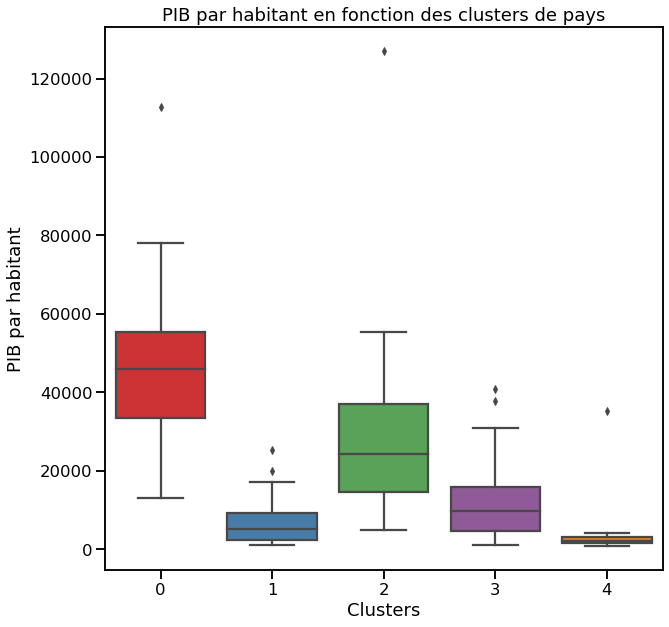

In [78]:
plt.figure(figsize=(10,10))

_ = sns.boxplot(x='kmeans_cluster', y='PIB_hab', data=data)
_ = plt.xlabel('Clusters')
_ = plt.ylabel('PIB par habitant')
_ = plt.title('PIB par habitant en fonction des clusters de pays')

_ = plt.savefig('Boxplot_PIB.jpg')

_ = plt.show()

Précédemment, nous avions vu que le PIB par habitant ne suivait pas la loi normale. On va donc choisir de faire un test de Mann-Whitney pour juger de la significativité du PIB par habitant pour les clusters 1 et 3. La réalisation d'un test de Mann-Whitney ne demande pas de vérification particulière comme pour la réalisation d'un test paramétrique comme le test de Student.

In [84]:
clust1 = data[data["kmeans_cluster"]==1]["PIB_hab"]
clust2 = data[data["kmeans_cluster"]==3]["PIB_hab"]

# Réalisation d'un test de Mann-Whitney pour s'assurer de la significativité des différences
st.stats.mannwhitneyu(clust1, clust3)

MannwhitneyuResult(statistic=0.0, pvalue=8.583660949999248e-13)

Le résultat du test de Mann-Whitney montre une différence significative entre le cluster 1 et le cluster 3. Le PIB par habitant dans ces deux clusters sont donc différents.

### 6.7. Conclusion

Les pays du cluster 3 sont ceux ayant une croissance de population assez importante et un PIB par habitant moyen. On va donc chercher les pays-cible dans ce cluster. 

In [85]:
print(data.loc[data['kmeans_cluster'] == 3].index)

Index(['Barbade', 'Bangladesh', 'Belize', 'Bulgarie', 'Myanmar', 'Cameroun',
       'Sri Lanka', 'Chypre', 'Bénin', 'Dominique', 'République dominicaine',
       'Équateur', 'El Salvador', 'Fidji', 'Djibouti', 'Géorgie', 'Guinée',
       'Guyana', 'Indonésie', 'Côte d'Ivoire', 'Jamaïque', 'Japon', 'Jordanie',
       'Liban', 'Malawi', 'Népal', 'Vanuatu', 'Nicaragua', 'Paraguay',
       'Philippines', 'Sainte-Lucie', 'Sénégal', 'Slovaquie', 'Suriname',
       'Thaïlande', 'Burkina Faso', 'Serbie'],
      dtype='object', name='pays')


In [86]:
choix_pays = data.loc[(data['kmeans_cluster']== 3)]
choix_pays = choix_pays.sort_values(['croissance_pop', 'PIB_hab'], ascending=False)
print(choix_pays)

                        croissance_pop  PIB_hab  prot_anim_prot_tot  \
pays                                                                  
Burkina Faso                      2.93   2053.5               14.38   
Sénégal                           2.84   3203.9               21.51   
Guinée                            2.80   2420.6               18.44   
Bénin                             2.79   3044.5               22.33   
Malawi                            2.70   1037.5               16.86   
Cameroun                          2.67   3554.5               16.23   
Côte d'Ivoire                     2.58   4830.8               23.18   
Vanuatu                           2.58   3121.1               39.78   
Jordanie                          2.42   9841.2               34.92   
Belize                            2.00   7108.9               37.89   
Équateur                          1.78  11617.9               45.52   
Djibouti                          1.61   4885.2               19.33   
Liban 

Parmi cette liste, on peut retenir que la Jordanie, l'Equateur, le Liban, le Paraguay et l'Indonésie peuvent constituer des pays-cibles intéressants pour développer un marché à l'international.